![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)

# Retrieval Augmented Generation (RAG) Challenge

## Introduction
---------------------------------------

Retrieval Augmented Generation (RAG) is a novel approach that combines the strengths of retrieval-based and generation-based models to provide accurate and contextually relevant responses. By leveraging a vector database to retrieve relevant documents and a large language model (LLM) to generate responses, RAG can significantly enhance the capabilities of applications in various domains such as customer support, knowledge management, and content creation.

## Exploratory Data Analysis (EDA)

- Analyze dataset structure, quality, and distribution.
- Identify missing data, bias, or inconsistencies.
- Tokenization and text length distribution analysis.
- Visualize key patterns (word clouds, embeddings, etc.).


### Load and Extract Text from PDFs

In [7]:
#!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 16.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import fitz  # PyMuPDF

# Define the folder containing PDFs
pdf_folder = pdf_folder = '/Users/paolarivera/Documents/Ironhack/Week 8/Day 3 Project /project-5-2-genai-rag-main/data/financial_laws_pdfs'
output_folder = '/Users/paolarivera/Documents/Ironhack/Week 8/Day 3 Project /project-5-2-genai-rag-main/data/extracted_texts'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to extract text from a PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    doc = fitz.open(pdf_path)
    for page in doc:
        text += page.get_text("text") + "\n"
    return text

# Process each PDF
for pdf_file in os.listdir(pdf_folder):
    if pdf_file.endswith(".pdf"):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        extracted_text = extract_text_from_pdf(pdf_path)

        # Save the extracted text to a .txt file
        text_filename = os.path.splitext(pdf_file)[0] + ".txt"
        with open(os.path.join(output_folder, text_filename), "w", encoding="utf-8") as text_file:
            text_file.write(extracted_text)

        print(f"Extracted text from: {pdf_file}")

print("Extraction complete! All texts saved in", output_folder)

Extracted text from: DGSD_EURLEX.pdf
Extracted text from: BRRD_EURLEX.pdf
Extracted text from: PSD_EURLEX.pdf
Extracted text from: IFD_EURLEX.pdf
Extracted text from: IFR_EURLEX.pdf
Extracted text from: AMLD_EURLEX.pdf
Extracted text from: SecReg_EURLEX.pdf
Extracted text from: MCD_EURLEX.pdf
Extracted text from: WTR_EURLEX.pdf
Extracted text from: CRR_EURLEX.pdf
Extracted text from: CRD_EURLEX.pdf
Extraction complete! All texts saved in /Users/paolarivera/Documents/Ironhack/Week 8/Day 3 Project /project-5-2-genai-rag-main/data/extracted_texts


### EDA

In [3]:
import os
import re
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paolarivera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
import pandas as pd

# Path to extracted text files
data_path = "/Users/paolarivera/Documents/Ironhack/Week 8/Day 3 Project /project-5-2-genai-rag-main/data/extracted_texts"

# Read all extracted text files
documents = []
for file in os.listdir(data_path):
    if file.endswith(".txt"):
        with open(os.path.join(data_path, file), "r", encoding="utf-8") as f:
            text = f.read()
            documents.append({"filename": file, "content": text})

df = pd.DataFrame(documents)
df.head()

,filename,content
0,IFD_EURLEX.txt,DIRECTIVES \nDIRECTIVE (EU) 2019/2034 OF THE E...
1,IFR_EURLEX.txt,I \n(Legislative acts) \nREGULATIONS \nREGULAT...
2,DGSD_EURLEX.txt,DIRECTIVES \nDIRECTIVE 2014/49/EU OF THE EUROP...
3,BRRD_EURLEX.txt,DIRECTIVE 2014/59/EU OF THE EUROPEAN PARLIAMEN...
4,PSD_EURLEX.txt,DIRECTIVES \nDIRECTIVE (EU) 2015/2366 OF THE E...


In [9]:
# Path to extracted text files
data_path = "/Users/paolarivera/Documents/Ironhack/Week 8/Day 3 Project /project-5-2-genai-rag-main/data/extracted_texts"

# Read and inspect raw text
sample_texts = []
for file in os.listdir(data_path):
    if file.endswith(".txt"):
        with open(os.path.join(data_path, file), "r", encoding="utf-8") as f:
            text = f.read()
            sample_texts.append((file, text[:1000]))  # Print first 1000 characters for preview

# Check raw text samples
for filename, text in sample_texts[:2]:  # Show first 2 samples
    print(f"--- {filename} ---")
    print(text)
    print("\n" + "="*80 + "\n")

--- IFD_EURLEX.txt ---
DIRECTIVES 
DIRECTIVE (EU) 2019/2034 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL 
of 27 November 2019 
on the prudential supervision of investment firms and amending Directives 2002/87/EC, 
2009/65/EC, 2011/61/EU, 2013/36/EU, 2014/59/EU and 2014/65/EU 
(Text with EEA relevance) 
THE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EUROPEAN UNION, 
Having regard to the Treaty on the Functioning of the European Union, and in particular Article 53(1) thereof, 
Having regard to the proposal from the European Commission, 
After transmission of the draft legislative act to the national parliaments, 
Having regard to the opinion of the European Central Bank (1), 
Having regard to the opinion of the European Economic and Social Committee (2), 
Acting in accordance with the ordinary legislative procedure (3), 
Whereas: 
(1) 
Robust prudential supervision is an integral part of the regulatory conditions under which financial institutions 
provide services within the Union. Inv

In [11]:
# Path to extracted text files
text_folder = '/Users/paolarivera/Documents/Ironhack/Week 8/Day 3 Project /project-5-2-genai-rag-main/data/extracted_texts'  # Update with actual path
text_files = glob.glob(os.path.join(text_folder, "*.txt"))

# Read all text files
documents = []
for file in text_files:
    with open(file, "r", encoding="utf-8") as f:
        documents.append(f.read())

In [13]:
# Basic Stats
doc_lengths = [len(word_tokenize(doc)) for doc in documents]

print("Total number of documents:", len(documents))
print("Average document length (words):", sum(doc_lengths) / len(doc_lengths))
print("Max document length (words):", max(doc_lengths))
print("Min document length (words):", min(doc_lengths))

Total number of documents: 11
Average document length (words): 63728.90909090909
Max document length (words): 253151
Min document length (words): 11548


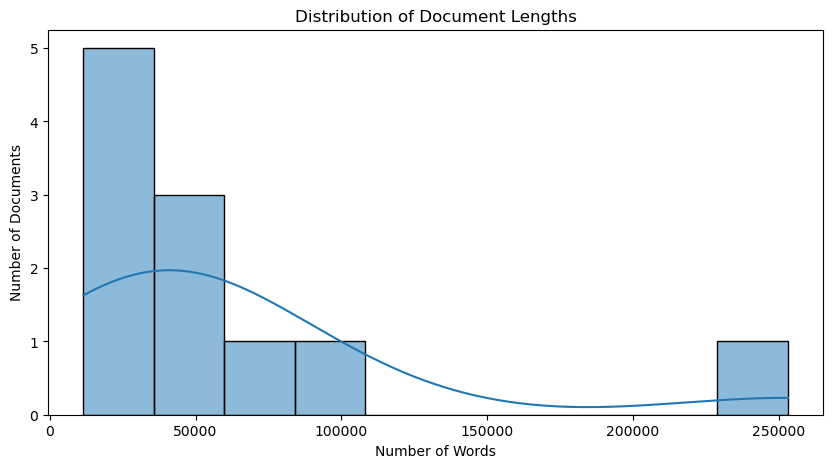

In [15]:
# Plot document length distribution
plt.figure(figsize=(10,5))
sns.histplot(doc_lengths, bins=10, kde=True)
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.title("Distribution of Document Lengths")
plt.show()

In [17]:
# Word Frequency Analysis
all_text = " ".join(documents)
tokens = word_tokenize(all_text)
token_counts = Counter(tokens)

In [18]:
# Most common bigrams and trigrams
bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))

bigram_counts = Counter(bigrams).most_common(10)
trigram_counts = Counter(trigrams).most_common(10)

print("Top 10 Bigrams:", bigram_counts)
print("Top 10 Trigrams:", trigram_counts)

Top 10 Bigrams: [(('of', 'the'), 10686), ((';', '('), 4324), (('to', 'the'), 3694), (('in', 'the'), 2892), ((',', 'the'), 2577), (('1', ')'), 2576), (('(', '1'), 2497), (('referred', 'to'), 2282), (('to', 'in'), 2224), ((')', 'of'), 2218)]
Top 10 Trigrams: [(('(', '1', ')'), 2495), (('referred', 'to', 'in'), 2223), (('in', 'accordance', 'with'), 2141), (('(', 'b', ')'), 1905), (('(', 'a', ')'), 1892), (('(', 'EU', ')'), 1675), (('of', 'the', 'European'), 1664), (('Regulation', '(', 'EU'), 1380), (('EU', ')', 'No'), 1321), (('(', '2', ')'), 1269)]


### Text Preprocessing
Since these documents are from the Official Journal of the European Union, they contain references, footnotes, legal symbols, and formatting artifacts that we should clean up.

In [22]:
import string

def clean_text(text):
    """
    We clean the extracted text by:
    - Removing extra newlines and spaces
    - Removing page numbers and unwanted headers
    - Removing special characters
    - Normalizing unicode
    """
    # Remove extra spaces and newlines
    text = re.sub(r'\n+', '\n', text)  # Remove multiple newlines
    text = re.sub(r'\s+', ' ', text)  # Collapse multiple spaces
    
    # Remove page numbers and headers (example: "Page 12 of 50")
    text = re.sub(r'Page \d+ of \d+', '', text, flags=re.IGNORECASE)
    
    # Remove special characters (except basic punctuation)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Normalize unicode (e.g., remove weird characters)
    text = text.encode("utf-8", "ignore").decode()

    return text.strip()

# Apply cleaning to all texts
cleaned_documents = []
for file in os.listdir(data_path):
    if file.endswith(".txt"):
        with open(os.path.join(data_path, file), "r", encoding="utf-8") as f:
            raw_text = f.read()
            cleaned_text = clean_text(raw_text)
            cleaned_documents.append({"filename": file, "content": cleaned_text})

In [24]:
import re
import string
import unicodedata

def advanced_clean_text(text):
    """
    We can clean legal text further by:
    - Removing unwanted legal references (e.g., [Article 12], [Section IV])
    - Removing tables, footnotes, and bibliography sections
    - Handling case normalization
    - Removing special characters and boilerplate text
    """

    # Normalize Unicode characters
    text = unicodedata.normalize("NFKD", text)

    # Remove references like [Article 12] or [Section IV]
    text = re.sub(r"\[.*?\]", "", text)

    # Remove page numbers and headers (e.g., "Page 12 of 50")
    text = re.sub(r"Page \d+ of \d+", "", text, flags=re.IGNORECASE)

    # Remove table-like structures (rows of numbers, e.g., "1.2 | 3.4 | 5.6")
    text = re.sub(r"(\d+(\.\d+)?\s*\|\s*)+\d+(\.\d+)?", "", text)

    # Remove common legal boilerplate text (add more patterns as needed)
    boilerplate_patterns = [
        r"This document is for informational purposes only.*",  # Common disclaimer
        r"All rights reserved.*",
        r"Reproduction or distribution is prohibited.*"
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, "", text, flags=re.IGNORECASE)

    # Remove footnotes (assuming they start with numbers)
    text = re.sub(r"\d+\.\s.*", "", text)

    # Remove legal symbols and abbreviations (e.g., "§", "Art.", "No.")
    text = re.sub(r"§|\bArt\.|\bNo\.", "", text)

    # Remove excessive whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [26]:
# Apply advanced cleaning
cleaned_documents = []
for file in os.listdir(data_path):
    if file.endswith(".txt"):
        with open(os.path.join(data_path, file), "r", encoding="utf-8") as f:
            raw_text = f.read()
            cleaned_text = advanced_clean_text(raw_text)
            cleaned_documents.append({"filename": file, "content": cleaned_text})


In [32]:
import random

# Select a random sample
sample_doc = random.choice(cleaned_documents)
print(f"📄 File: {sample_doc['filename']}\n")
print(sample_doc["content"][:1000])  # Show first 1000 characters


📄 File: IFR_EURLEX.txt

I (Legislative acts) REGULATIONS REGULATION (EU) 2019/2033 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL of 27 November 2019 on the prudential requirements of investment firms and amending Regulations (EU) No 1093/2010, (EU) No 575/2013, (EU) No 600/2014 and (EU) No 806/2014 (Text with EEA relevance) THE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EUROPEAN UNION, Having regard to the Treaty on the Functioning of the European Union, and in particular Article 114 thereof, Having regard to the proposal from the European Commission, After transmission of the draft legislative act to the national parliaments, Having regard to the opinion of the European Central Bank (1), Having regard to the opinion of the European Economic and Social Committee (2), Acting in accordance with the ordinary legislative procedure (3), Whereas: (1) Robust prudential requirements are an integral part of the regulatory conditions under which financial institutions provide services within the

In [34]:
# Define the output directory for cleaned texts
cleaned_texts_path = "/Users/paolarivera/Documents/Ironhack/Week 8/Day 3 Project/project-5-2-genai-rag-main/data/cleaned_texts"

# Create the folder if it doesn't exist
os.makedirs(cleaned_texts_path, exist_ok=True)

# Loop through cleaned documents and save them as text files
for doc in cleaned_documents:
    filename = os.path.join(cleaned_texts_path, doc["filename"])  # Keep original filename
    with open(filename, "w", encoding="utf-8") as f:
        f.write(doc["content"])

print(f" Cleaned text files saved to: {cleaned_texts_path}")

 Cleaned text files saved to: /Users/paolarivera/Documents/Ironhack/Week 8/Day 3 Project/project-5-2-genai-rag-main/data/cleaned_texts


In [36]:
os.listdir(cleaned_texts_path)

['IFD_EURLEX.txt',
 'IFR_EURLEX.txt',
 'DGSD_EURLEX.txt',
 'BRRD_EURLEX.txt',
 'PSD_EURLEX.txt',
 'WTR_EURLEX.txt',
 'CRR_EURLEX.txt',
 'CRD_EURLEX.txt',
 'AMLD_EURLEX.txt',
 'SecReg_EURLEX.txt',
 'MCD_EURLEX.txt']

In [30]:
df_clean = pd.DataFrame(cleaned_documents)
df_clean["num_words"] = df_clean["content"].apply(lambda x: len(x.split()))

# Compare before & after
df_comparison = pd.merge(df[["filename", "num_words"]], df_clean, on="filename", suffixes=("_before", "_after"))
print(df_comparison)

KeyError: "['num_words'] not in index"

### Basic EDA After Cleaning

           num_words
count      11.000000
mean    53755.545455
std     58782.187294
min      8981.000000
25%     24457.500000
50%     34860.000000
75%     56668.500000
max    217635.000000


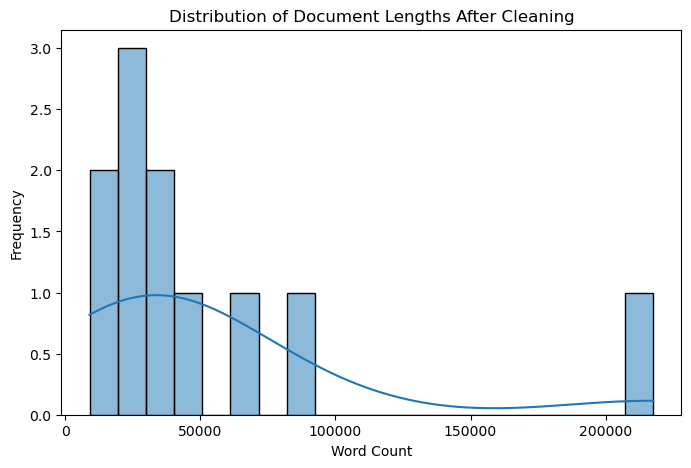

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to DataFrame
df = pd.DataFrame(cleaned_documents)
df["num_words"] = df["content"].apply(lambda x: len(x.split()))

# Summary statistics
print(df.describe())

# Plot distribution of document lengths
plt.figure(figsize=(8,5))
sns.histplot(df["num_words"], bins=20, kde=True)
plt.title("Distribution of Document Lengths After Cleaning")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

## Embedding and Storing Chunks

#### 3.1 Chunk the Text

In [36]:
#pip install langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [67]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Define chunking function
def chunk_text(text, chunk_size=500, overlap=100):
    """
    Splits text into overlapping chunks.
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, 
        chunk_overlap=overlap
    )
    return text_splitter.split_text(text)

# Apply chunking
chunked_data = []
for doc in cleaned_documents:
    chunks = chunk_text(doc["content"])
    for i, chunk in enumerate(chunks):
        chunked_data.append({
            "filename": doc["filename"],
            "chunk_id": i,
            "content": chunk
        })

# Convert to DataFrame for easier manipulation
df_chunks = pd.DataFrame(chunked_data)

# Show results
df_chunks.head()

,filename,chunk_id,content
0,IFD_EURLEX.txt,0,DIRECTIVES DIRECTIVE (EU) 2019/2034 OF THE EUR...
1,IFD_EURLEX.txt,1,"Union, and in particular Article 53(1) thereof..."
2,IFD_EURLEX.txt,2,(1) Robust prudential supervision is an integr...
3,IFD_EURLEX.txt,3,"treatment and supervision, while their authori..."
4,IFD_EURLEX.txt,4,the Basel Committee on Banking Supervision and...


#### 3.2 Generate Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer

# Load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Compute embeddings
df_chunks["embedding"] = df_chunks["content"].apply(lambda x: embedding_model.encode(x))

# Show sample embedding
print(df_chunks.iloc[0]["embedding"][:5])  # Print first 5 dimensions